<a href="https://colab.research.google.com/github/envgp/taking_the_pulse_atmosphere/blob/main/pulse_atmosphere_greenhouse_gases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1: Atmosphere: Green House Gases

Rosemary Knight (rknight@stanford.edu) & Seogi Kang (sgkang09@stanford.edu), Stanford Environmental Geophysics Group

This week, we will explore green houses gases including CO2, CH4, NO2, XXX in the atmospheric system, which drives the climate change. Data sets used this lab are: 1) XXX. 

XXX

In [1]:
# !pip install xarray numpy pandas geopandas cartopy==0.19.0.post1 ipywidgets

In [2]:
# !pip uninstall -y shapely

In [3]:
# !pip install shapely --no-binary shapely

## Download required data

In [6]:
!git clone https://premonition.stanford.edu/sgkang09/taking_the_pulse_atmosphere_data.git

Cloning into 'taking_the_pulse_atmosphere_data'...
Updating files:  88% (8/9)
Updating files: 100% (9/9)
Updating files: 100% (9/9), done.


In [8]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import warnings
warnings.filterwarnings('ignore')

## CO2 data

### Understanding data


<img src="https://climate.nasa.gov/rails/active_storage/blobs/redirect/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbTB1IiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--316f6ecc3277fe90f8001ccabd62210d74792a1d/co2_left_061720.gif?disposition=inline"></img>

Data source: Reconstruction from ice cores.

Credit: NOAA


[COPIED FROM NASA WEBPAGE]

The first graph shows atmospheric CO2 levels measured at Mauna Loa Observatory, Hawaii, in recent years, with natural, seasonal changes removed. The second graph shows CO2 levels during Earth’s last three glacial cycles, as captured by air bubbles trapped in ice sheets and glaciers.

Since the beginning of industrial times (in the 18th century), human activities have raised atmospheric CO2 by 50% – meaning the amount of CO2 is now 150% of its value in 1750. This is greater than what naturally happened at the end of the last ice age 20,000 years ago.

Let's start with a monthly time-series of CO2 level measured at Mauna Loa Observatory. We are going to read the CO2 level a csv format using `pandas`. 

In [9]:
df_co2 = pd.read_csv('./taking_the_pulse_atmosphere_data/co2_gml.csv')

In [10]:
df_co2.head()

,year,month,monthly_average_co2,de-seasonalized_co2
0,1958.0,3.0,315.70,314.43
1,1958.0,4.0,317.45,315.16
2,1958.0,5.0,317.51,314.71
3,1958.0,6.0,317.24,315.14
4,1958.0,7.0,315.86,315.18


In [11]:
# generate DatetimeIndex from years and months
years = df_co2['year'].values.astype(int)
months = df_co2['month'].values.astype(int)
times = [datetime.date(years[ii], months[ii], 1) for ii in range(df_co2.shape[0])]
time_series = pd.to_datetime(times)
df_co2['time'] = time_series
df_co2 = df_co2.set_index('time')

In [12]:
df_co2.head(3)

,year,month,monthly_average_co2,de-seasonalized_co2
time,,,,
1958-03-01,1958.0,3.0,315.70,314.43
1958-04-01,1958.0,4.0,317.45,315.16
1958-05-01,1958.0,5.0,317.51,314.71


Although the table includes `de-seasonalized_co2`, as an exercise we are going to remove seasonal changes by using a moving average. 

In [13]:
df_series = df_co2['monthly_average_co2'].rolling(window=12, center=True).mean()

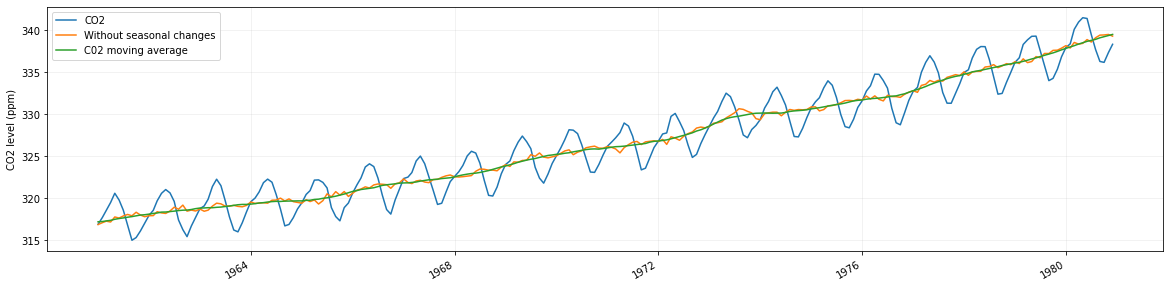

In [65]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
year_min = 1960
year_max = 1980
index_time = np.logical_and(year_min<time_series.year, year_max>=time_series.year)
ax.plot(time_series[index_time], df_co2['monthly_average_co2'].values[index_time], label="CO2", marker='None')
ax.plot(time_series[index_time], df_co2['de-seasonalized_co2'].values[index_time], label="Without seasonal changes", marker='None')
df_series.loc[time_series[index_time]].plot(label='C02 moving average')
ax.grid(True, alpha=0.2)
ax.set_ylabel("CO2 level (ppm)")

ax.legend()

In [71]:
def linear_fit(time_series, data):
    # assume the time series has a regular sampling rate
    times = np.arange(len(time_series))
    G = np.c_[times, np.ones_like(times)]
    Pinv = np.linalg.pinv(G)
    m = Pinv.dot(data)
    predicted_data = G @ m
    return predicted_data

In [72]:
predicted_data = linear_fit(time_series[index_time], df_co2['monthly_average_co2'].values[index_time])

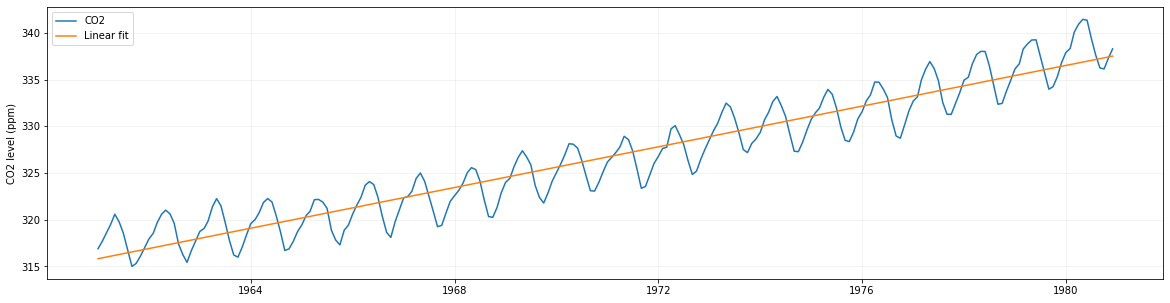

In [73]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.plot(time_series[index_time], df_co2['monthly_average_co2'].values[index_time], label="CO2", marker='None')
ax.plot(time_series[index_time], predicted_data, label="Linear fit", marker='None')
ax.grid(True, alpha=0.2)
ax.set_ylabel("CO2 level (ppm)")

ax.legend()

Now, we are going to load the gridded CO2 data measured ...

In [74]:
co2_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/co2.nc')

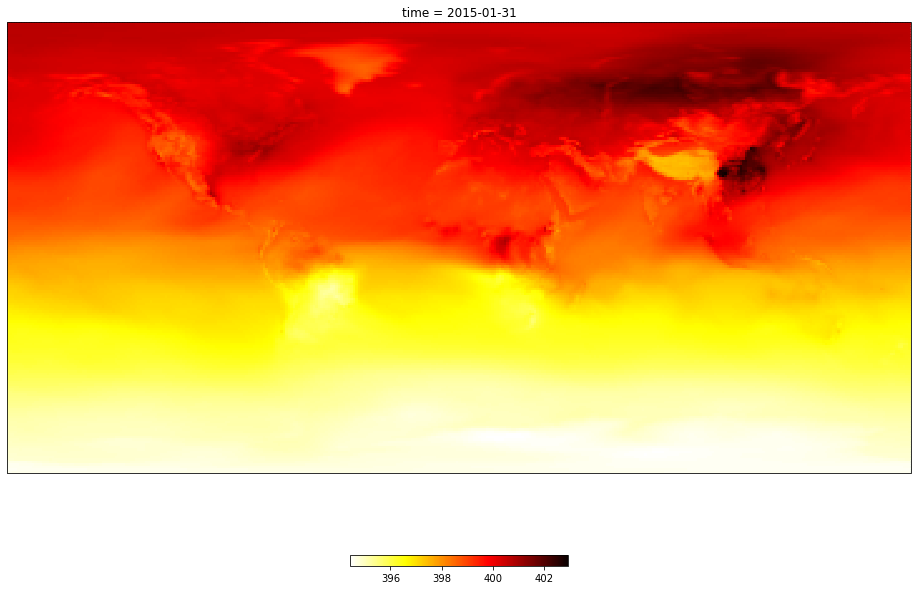

In [75]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
out = co2_data.co2.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r')
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

Text(0.5, 0, 'CO2 level (ppm)')

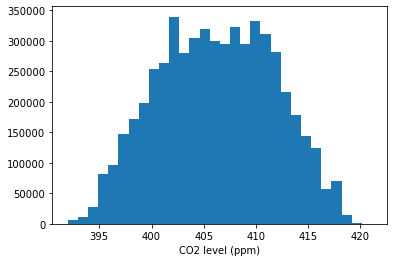

In [76]:
out = plt.hist(co2_data.co2.data.flatten(), bins=30)
plt.xlabel("CO2 level (ppm)")

In [77]:
from ipywidgets import widgets, interact
def plot_co2(i_time):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    out = co2_data.co2.isel(time=i_time).plot(
        ax=ax, add_colorbar=False, cmap='hot_r', 
        vmin=390, vmax=420
      )
    plt.colorbar(out, fraction=0.02, orientation='horizontal')
    ax.set_aspect(1)
    ax.set_facecolor('lightblue')  
    plt.show()

In [78]:
interact(plot_co2, i_time = widgets.IntSlider(min=0, max=83, step=6))

interactive(children=(IntSlider(value=0, description='i_time', max=83, step=6), Output()), _dom_classes=('widg…

<function __main__.plot_co2(i_time)>

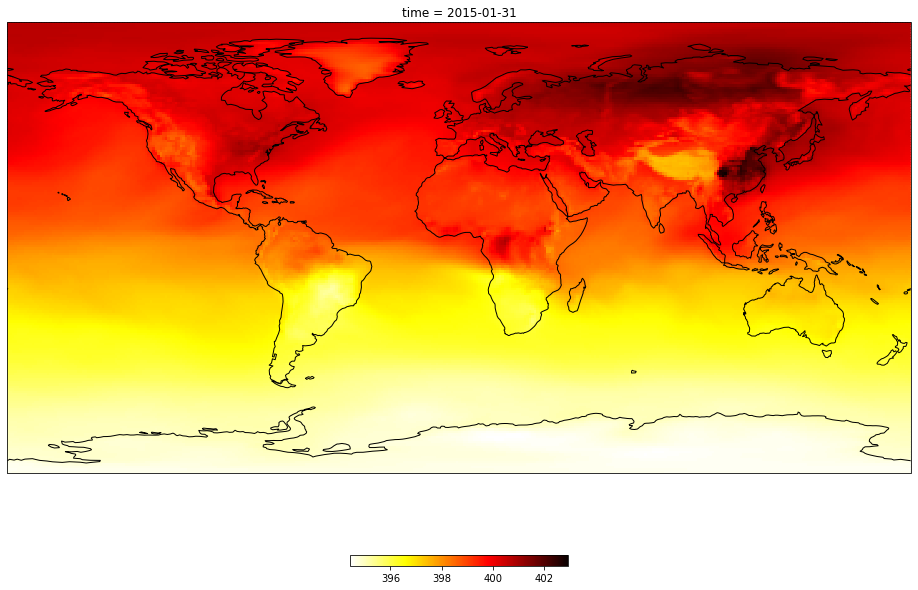

In [79]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = co2_data.co2.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r')
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)

ax.set_facecolor('lightblue')

In [80]:
co2_data.sel(time=pd.to_datetime(co2_data.time.data)[30])

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
    time     datetime64[ns] 2017-07-31
  * lon      (lon) float64 -179.8 -178.8 -177.8 -176.8 ... 177.2 178.2 179.2
  * lat      (lat) float64 89.75 88.75 87.75 86.75 ... -87.25 -88.25 -89.25
Data variables:
    co2      (lat, lon) float64 401.6 401.6 401.6 401.6 ... 401.1 401.1 401.1
Attributes:
    Description:    CO2 data
    Unit:           ppmv (part per million per volume)
    Data document:  https://disc.gsfc.nasa.gov/datasets/OCO2_GEOS_L3CO2_MONTH...

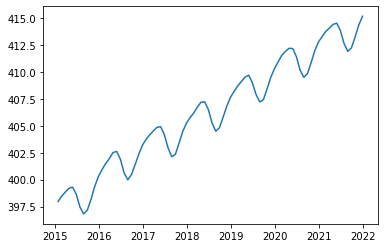

In [81]:
co2_mean_time_series = co2_data.mean(dim=['lat','lon'])
plt.plot(co2_mean_time_series.time, co2_mean_time_series.co2.data)

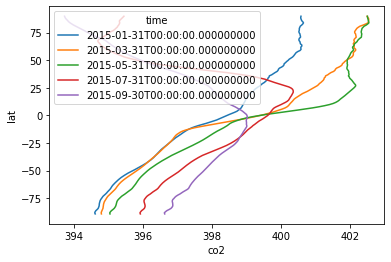

In [82]:
co2_lat = co2_data.mean(dim=['lon'])
co2_lat['co2'].isel(time=[0, 2, 4, 6, 8]).plot.line(y='lat', hue='time')

Let's estimate the linear trend for the gridded CO2 data

In [112]:
def linear_fit(time_series, data):
    # assume the time series has a regular sampling rate
    times = np.arange(len(time_series))
    G = np.c_[times, np.ones_like(times)]
    Pinv = np.linalg.pinv(G)
    m = Pinv.dot(data)
    predicted_data = G @ m
    slope = m[0,:]
    intercept = m[1,:]
    return predicted_data, slope, intercept

In [118]:
co2_vec = co2_data.co2.data.reshape((co2_data.co2.data.shape[0], np.prod(co2_data.co2.data.shape[1:])))
time_series = co2_data.time.data
co2_linear_fit, slope, intercept = linear_fit(time_series, co2_vec)

In [150]:
co2_data['slope'] = (("lat", "lon"), slope.reshape(co2_data.co2.data.shape[1:]))
co2_data['intercept'] = (("lat", "lon"), intercept.reshape(co2_data.co2.data.shape[1:]))
co2_data['co2_linear_fit'] = (("time", "lat", "lon"), co2_linear_fit.reshape(co2_data.co2.data.shape))

Sanity check by looking at the mean time-series

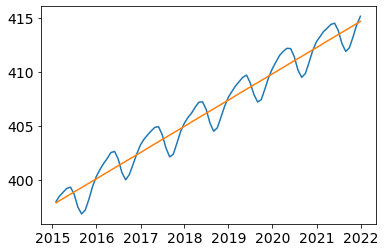

In [155]:
co2_mean_time_series = co2_data.mean(dim=['lat','lon'])
plt.plot(co2_mean_time_series.time, co2_mean_time_series.co2.data)
plt.plot(co2_mean_time_series.time, co2_mean_time_series.co2_linear_fit.data)

In [159]:
co2_data.attrs

{'Description': 'CO2 data',
 'Unit': 'ppmv (part per million per volume)',
 'Data document': 'https://disc.gsfc.nasa.gov/datasets/OCO2_GEOS_L3CO2_MONTH_10r/summary'}

In [156]:
year_min = pd.to_datetime(time_series).min().strftime('%Y')
year_max = pd.to_datetime(time_series).max().strftime('%Y')

In [157]:
matplotlib.rcParams['font.size'] = 14

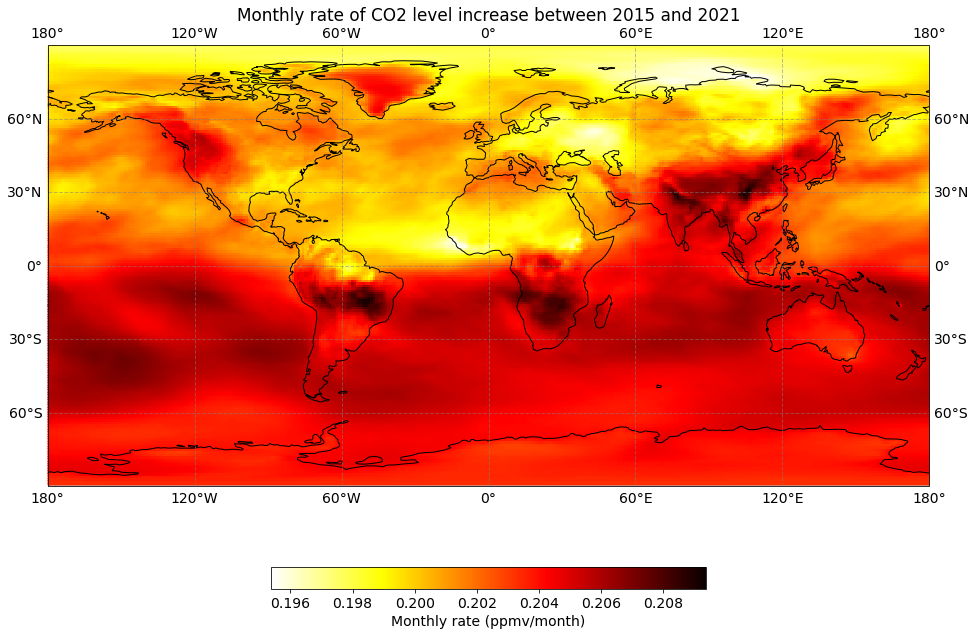

In [147]:
fig = plt.figure(figsize=(20, 10))
i_time = 0

ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = co2_data['slope'].plot(ax=ax, add_colorbar=False, cmap='hot_r')
cb = plt.colorbar(out, fraction=0.04, orientation='horizontal')
cb.set_label("Monthly rate (ppmv/month)")
ax.set_aspect(1)
ax.set_facecolor('lightblue')
ax.set_title("Monthly rate of CO2 level increase between {:s} and {:s}".format(year_min, year_max))

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=1, 
    color='gray', 
    alpha=0.5, 
    linestyle='--'
)

## Other operations

- parquet data
- groupby
- find cells in a polygon, then calculating sum or mean...



https://disc.gsfc.nasa.gov/datasets/SNDRAQIL3CMCCP_2/summary

In [ ]:
# gdf = gpd.read_file("D:/pulse_course/Pulse_CO2_CH4-20221219T221922Z-001/Pulse_CO2_CH4/Shapefiles/CONUS_shapefile_EPSG4326/cb_2015_us_state_500k.shp")

## CO data

### Understanding data

In [ ]:
co_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/co.nc')

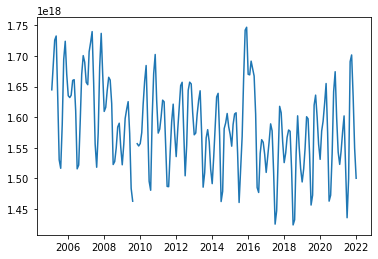

In [ ]:
co_mean_time_series = co_data.mean(dim=['lat','lon'])
plt.plot(co_mean_time_series.time, co_mean_time_series.co.data)

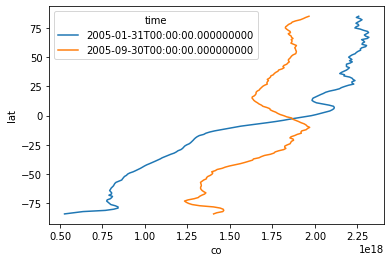

In [ ]:
co_lat = co_data.mean(dim=['lon'])
co_lat['co'].isel(time=[0, 8]).plot.line(y='lat', hue='time')

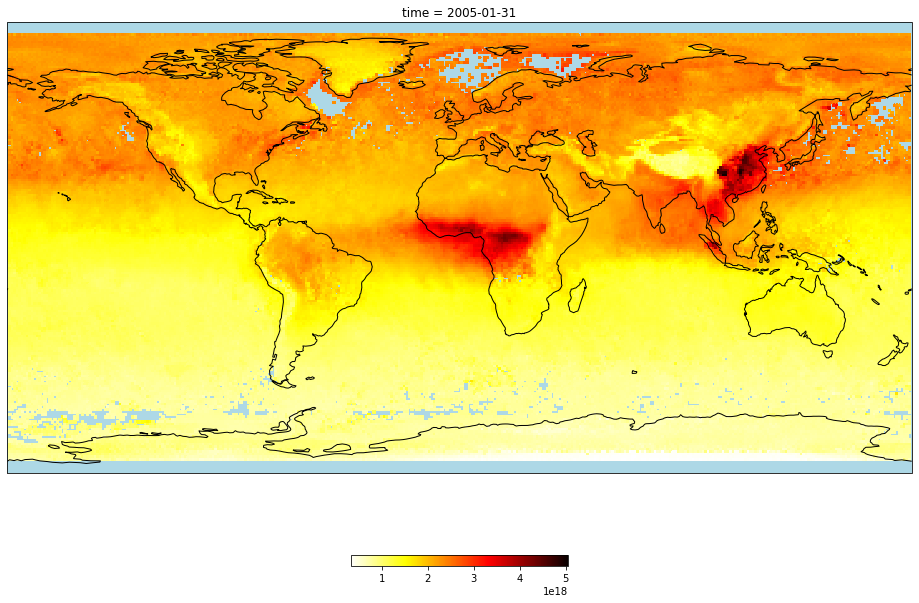

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = co_data.co.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r')
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

## NO2 data

### Understanding data

In [ ]:
no2_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/no2.nc')

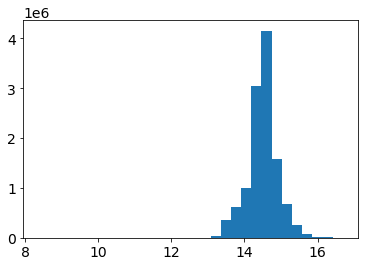

In [ ]:
out = plt.hist(np.log10(no2_data.no2.data.flatten()), bins=30)

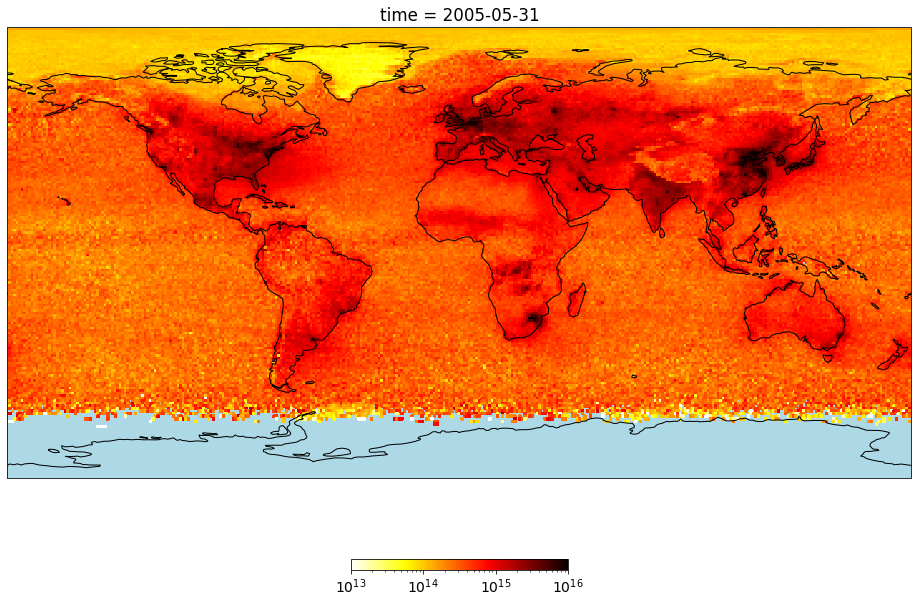

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 4
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = no2_data.no2.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r', norm=LogNorm(vmin=1e13, vmax=1e16))
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

## CH4 data

### Understanding data

In [ ]:
ch4_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/ch4.nc')

In [ ]:
ch4_data

<xarray.Dataset>
Dimensions:  (time: 3, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-28 2022-03-31 2022-04-30
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 89.97 88.97 87.97 86.97 ... -87.02 -88.02 -89.02
Data variables:
    ch4      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Description:    NO2 data
    Unit:           TBA
    Data document:  TBA

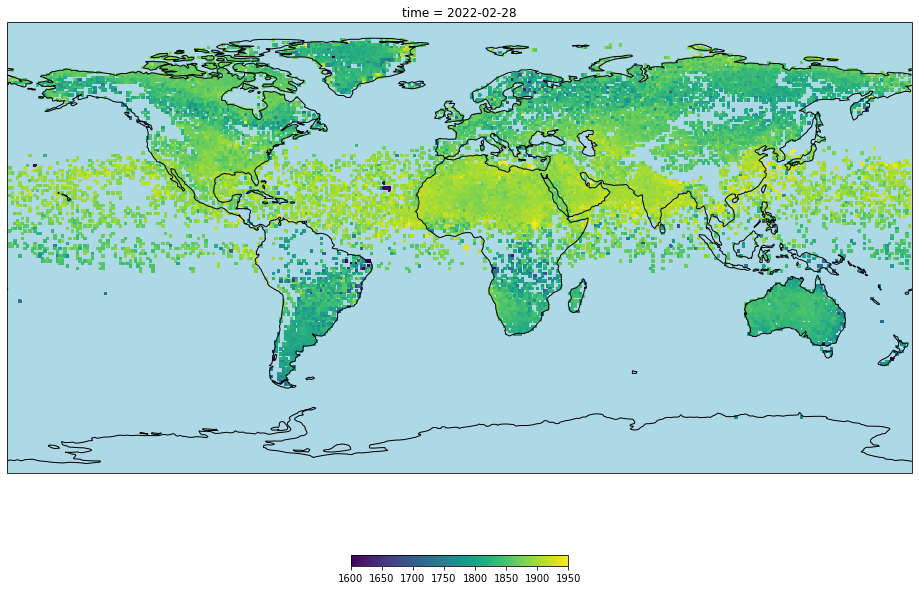

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = ch4_data.ch4.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='viridis', vmin=1600, vmax=1950)
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

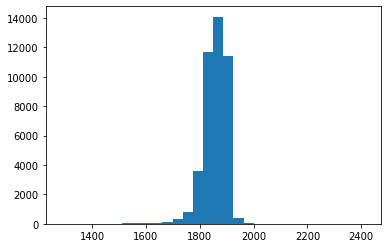

In [ ]:
out = plt.hist(ch4_data.ch4.data.flatten(), bins=30)

In [148]:
from ipywidgets import widgets, interact
def plot_map(i_time, data_type, scale):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    if data_type == 'co2':
        ds = co2_data.copy()
    elif data_type == 'co':
        ds = co_data.copy()
    elif data_type == 'no2':
        ds = no2_data.copy()
    elif data_type == 'ch4':
        ds = ch4_data.copy()
    norm = None
    if scale == 'log':
        norm = LogNorm()

    out = ds[data_type].isel(time=i_time).plot(
        ax=ax, add_colorbar=False, cmap='hot_r', norm=norm
        # vmin=390, vmax=420
      )
    plt.colorbar(out, fraction=0.02, orientation='horizontal')
    ax.set_aspect(1)
    ax.set_facecolor('lightblue')  
    plt.show()

In [149]:
interact(
    plot_map, 
    i_time = widgets.IntSlider(min=0, max=83, step=1), 
    data_type=widgets.Select(options=['co2', 'co', 'no2', 'ch4']), 
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=0, description='i_time', max=83), Select(description='data_type', option…

<function __main__.plot_map(i_time, data_type, scale)>